<a href="https://colab.research.google.com/github/Chovy-Culver/weatherwise-Chufengsheng-Zheng-doe/blob/main/WeatherWise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from datetime import datetime

def fetch_daily_weather(location):
    """
    Fetches 5-day forecast from OpenWeatherMap with one data point per day at 12:00 PM.

    Args:
        location (str): Name of the city (e.g., "Sydney")

    Returns:
        dict: {
            "city": str,
            "forecast": [
                {
                    "date": "YYYY-MM-DD",
                    "weather": str,
                    "temperature": float,
                    "humidity": int,
                    "precipitation": float,
                    "wind_speed": float
                }, ...
            ]
        }
        or None if the request fails
    """
    API_KEY = "1da7dea923d784a5dd83bac94cde8d65"
    url = f"https://api.openweathermap.org/data/2.5/forecast?q={location}&appid={API_KEY}&units=metric"

    try:
        response = requests.get(url)
        data = response.json()

        if response.status_code != 200 or "list" not in data:
            return None

        city = data["city"]["name"]
        raw_entries = data["list"]
        daily_forecast = []
        seen_dates = set()

        for entry in raw_entries:
            dt = datetime.strptime(entry["dt_txt"], "%Y-%m-%d %H:%M:%S")
            date_str = dt.strftime("%Y-%m-%d")
            hour = dt.strftime("%H")

            if date_str not in seen_dates and hour == "12":
                forecast = {
                    "date": date_str,
                    "weather": entry["weather"][0]["description"],
                    "temperature": entry["main"]["temp"],
                    "humidity": entry["main"]["humidity"],
                    "precipitation": entry.get("rain", {}).get("3h", 0.0),
                    "wind_speed": entry["wind"]["speed"]
                }
                daily_forecast.append(forecast)
                seen_dates.add(date_str)

        return {
            "city": city,
            "forecast": daily_forecast
        }

    except Exception:
        return None


# Example usage
if __name__ == "__main__":
    result = fetch_daily_weather("Perth")
    if result:
        from pprint import pprint
        pprint(result)
    else:
        print("No data returned.")



In [ ]:
def extract_weather_series(weather_data):
    """
    Extracts daily weather time series for plotting from structured weather data.

    Args:
        weather_data (dict): Output from fetch_daily_weather()

    Returns:
        dict: {
            "dates": [str],
            "temperature": [float],
            "precipitation": [float],
            "wind_speed": [float]
        }
        or None if input is invalid
    """
    if not weather_data or "forecast" not in weather_data:
        return None

    dates = []
    temperature = []
    precipitation = []
    wind_speed = []

    for entry in weather_data["forecast"]:
        dates.append(entry["date"])
        temperature.append(entry["temperature"])
        precipitation.append(entry["precipitation"])
        wind_speed.append(entry["wind_speed"])

    return {
        "dates": dates,
        "temperature": temperature,
        "precipitation": precipitation,
        "wind_speed": wind_speed
    }
# Call both functions to test
data = fetch_daily_weather("Perth")
if data:
    series = extract_weather_series(data)
    from pprint import pprint
    pprint(series)
else:
    print("No data returned.")

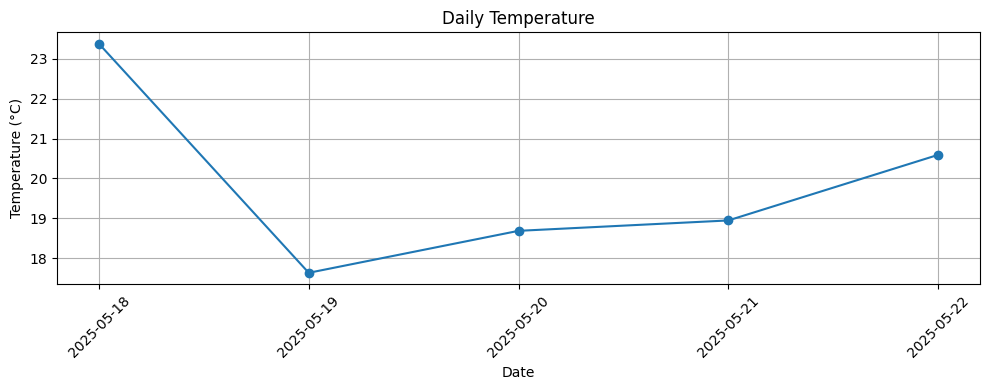

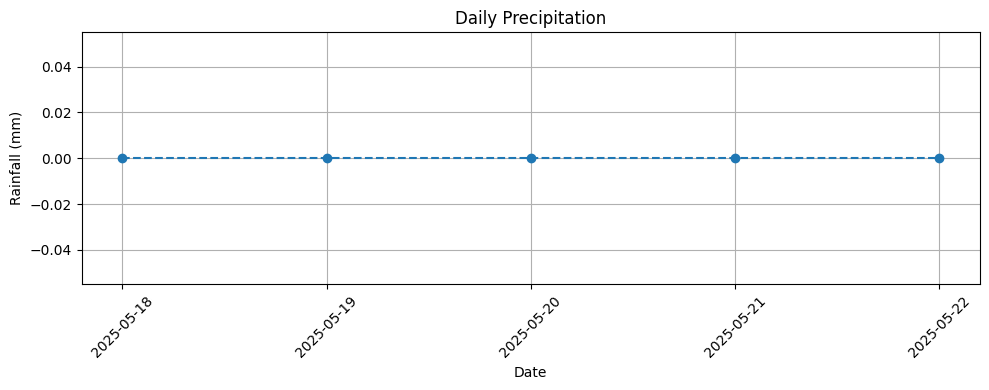

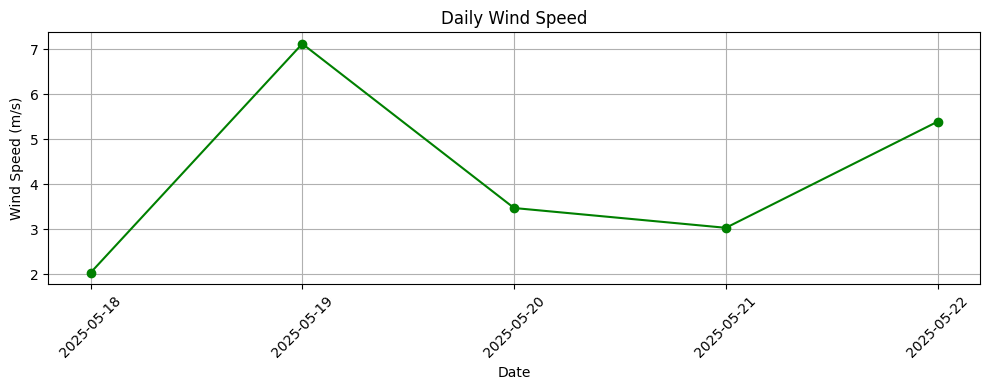

In [55]:
import matplotlib.pyplot as plt

def draw_weather_charts(series_data):
    """
    Draws separate line charts for temperature, precipitation, and wind speed.

    Args:
        series_data (dict): Output from extract_weather_series()
    """
    if not series_data:
        print("No data to plot.")
        return

    dates = series_data["dates"]
    temperature = series_data["temperature"]
    precipitation = series_data["precipitation"]
    wind_speed = series_data["wind_speed"]

    # Temperature plot
    plt.figure(figsize=(10, 4))
    plt.plot(dates, temperature, marker='o')
    plt.title("Daily Temperature")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Precipitation plot
    plt.figure(figsize=(10, 4))
    plt.plot(dates, precipitation, marker='o', linestyle='--')
    plt.title("Daily Precipitation")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Wind speed plot
    plt.figure(figsize=(10, 4))
    plt.plot(dates, wind_speed, marker='o', color='green')
    plt.title("Daily Wind Speed")
    plt.xlabel("Date")
    plt.ylabel("Wind Speed (m/s)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    data = fetch_daily_weather("Perth")
    if data:
        series = extract_weather_series(data)
        draw_weather_charts(series)
    else:
        print("No data available.")


In [83]:
import re
from datetime import datetime, timedelta

def parse_weather_question(question):
    """
    Parses a natural language weather question into structured components.

    Returns:
        dict: {
            "location": str or None,
            "date": str (YYYY-MM-DD) or None,
            "attribute": str ("temperature", "precipitation", "wind_speed")
        }
    """
    question = question.lower()

    # Step 1: Extract attribute
    if "rain" in question or "precipitation" in question:
        attribute = "precipitation"
    elif "wind" in question or "wind speed" in question:
        attribute = "wind_speed"
    elif "temperature" in question or "hot" in question or "cold" in question:
        attribute = "temperature"
    else:
        attribute = None

    # Step 2: Extract date
    today = datetime.today()
    weekdays = {
        "monday": 0, "tuesday": 1, "wednesday": 2,
        "thursday": 3, "friday": 4, "saturday": 5, "sunday": 6
    }

    if "today" in question:
        target_date = today
    elif "tomorrow" in question:
        target_date = today + timedelta(days=1)
    else:
        target_date = None
        for name, idx in weekdays.items():
            if name in question:
                delta = (idx - today.weekday()) % 7
                target_date = today + timedelta(days=delta)
                break

    # Step 3: Extract location correctly — split sentence & filter time keywords
    location = None
    if " in " in question:
        after_in = question.split(" in ", 1)[1]  # Take only the part after "in"
        excluded = {"today", "tomorrow"} | set(weekdays.keys())

        # Remove any time-related words from that part
        location_words = [word for word in after_in.split() if word not in excluded]
        if location_words:
            location = " ".join(location_words).title()

    return {
        "location": location,
        "date": target_date.strftime("%Y-%m-%d") if target_date else None,
        "attribute": attribute
    }


In [ ]:
ask_weather_question_dynamic()
